# Table of contents
1. [Prepare](#imports)
    1. [Packages](#imports)
    2. [Create Dictionaries](#dics)
2. [Comparing Variant Callers](#VC)
    1. [Load Data](#LoadData)
    2. [Calculate Concordane](#CalcConcordance)
    3. [Best Practices GATK](#BP)
    4. [DV+GLnexus](#DV_JG)
    5. [Comparing DV vs GATK](#DVvsGATK)
    6. [UPSET](#UPSET)
3. [Compare Quality metrics](#QualityMetrics)


Note: Jupyter Lab kept crashing due to exceeding RAM limitations. I've decided import the data and filter it and save the filtered dataset seperately and subsequently only imported the filtered dataset

## 1. Prepare <a name="imports"></a>
### A. Packages needed to import 

In [1]:
%pylab inline 
import pandas as pd
import os 
import plotly.express as px
import matplotlib.pyplot as plt
import itertools 
from matplotlib import gridspec
import plotly.io as pio
import seaborn as sns
import warnings
plt.style.use('seaborn')
warnings.filterwarnings('ignore')
pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'

Populating the interactive namespace from numpy and matplotlib


### B. Create dictionaries <a name="dics"></a>
- Sample names and relevant files is not included in the public notebook

In [11]:
dup74 = np.load('dup74.npy')

## 2. Compare Variant Callers <a name="VC"></a>

### A. Load Data <a name="LoadData"></a>

In [12]:
#Create filter for dataframe
#only include rare pathogenic variants 
def filter_df(dv):
    '''method to filter an annotated file to only rare pLOF variants 
    input is the dataframe and the output is filtered dataframe and blank'''
    dv = dv[dv['Func.refGene'].isin(['exonic', 'splicing'])]
    dv = dv[np.invert(dv['CLNSIG'].str.contains('Benign'))]
    dv = dv[np.invert(dv['CLNSIG'].str.contains('benign'))]
    dv = dv[np.invert(dv['ExonicFunc.refGene'].str.contains('nonframeshift'))]
    dv = dv[dv['genomicSuperDups']=='.']
    dv = dv[dv['AF'].replace('.', 0).astype(float)<.005]
    dv = dv[dv['ExonicFunc.refGene']!='synonymous SNV']
    keep = dv['CLNSIG'].isin(['Pathogenic', 'Pathogenic/Likely_pathogenic','Likely_pathogenic'])
    path_ind = list(keep[keep].index)
    drop = dv[(dv['ExonicFunc.refGene']=='nonsynonymous SNV')]['ClinPred_score'].replace('.', 0).astype(float)<0.85
    drop = drop[drop].index
    drop_ind = [i for i in drop if i not in path_ind]
    dv = dv.drop(drop_ind)
    blank = dv[dv.columns[-666]].value_counts().index[0]
    for samp in list(dv.columns[-666:]):
        ind = dv[samp].str.contains('0/0') | dv[samp].str.contains('0\|0') 
        replace_rows = ind[ind]
        dv.loc[replace_rows.index, samp] = blank
    dv = dv[sum(dv[dv.columns[-666:]]!=blank, axis =1)!=0]
    dv = dv[sum(dv[dv.columns[-666:]]!=blank, axis =1)<15]#random number to remove errors
    dv = dv.replace(blank, '.')
    return dv, '.' 


In [13]:
#make a list of df filtered callers from all 4 
#Get Data 
#df_list = []
#blanks = []
#callers = ['fb', 'dv', 'gatk', 'varscan']
#for caller in callers:
    #dv = pd.read_csv('Manuscript_Exome/Annovar_input/filt_{}_merge.hg19_multianno.txt'.format(caller), sep = '\t') #saved
    #dv = dv.rename(rename_cols, axis =1)
    #dv, blank = filter_df(dv)
    #dv.to_csv('Manuscript_Exome/SAVED_DF/rarepath_filt_{}_merge.hg19_multianno.txt'.format(caller), index = None, sep = '\t')
    #print(dv.shape)

In [14]:
#make a list of df filtered callers from all 4 
#Get Data 
df_list = []
blanks = ['.', '.', '.', '.']
callers = ['fb', 'dv', 'gatk', 'varscan']
for caller in callers:
    dv = pd.read_csv('Manuscript_Exome/SAVED_DF/rarepath_filt_{}_merge.hg19_multianno.txt'.format(caller), sep = '\t')
    print(dv.shape)
    df_list.append(dv)

(48866, 803)
(26288, 803)
(35812, 803)
(22905, 803)


In [15]:
#function to add Chr_StartPos_Ref_Alt 
def create_variant_index(df):
    index = df['Chr']+'_'+df['Start'].astype(str)+'_'+df['Ref']+'_'+df['Alt']
    return index

In [16]:
#create a variant index for each caller
variant_index = []
for i in df_list:
    variant_index.append(create_variant_index(i))

In [17]:
#rename_replicates to Rep1a, Rep1b etc. 
rename_rep = {}
for ind, group in enumerate(dup74): 
    for abcd, samp in enumerate(group):
        rename_rep[samp] = 'Rep'+str(ind)+['a', 'b', 'c', 'd'][abcd]

part2 = dv[rename_rep.keys()].rename(rename_rep,axis=1)
repdf = pd.concat([dv[dv.columns[:-666]], part2], axis =1)

In [18]:
def count_SNP_Indel_calls(dv, blank):
    '''Count the number of SNPs and InDels in eachdataframe '''
    temp = []
    for index, row in dv.iterrows():
        if (row['Ref']=='-') or (row['Alt']=='-'):
            for loop in range(sum(row[dv.columns[-666:]]!=blank)):
                temp.append('InDel')
        elif len(row['Ref'])==len(row['Alt']):
            for loop in range(sum(row[dv.columns[-666:]]!=blank)):
                temp.append('SNP')
        else: 
            for loop in range(sum(row[dv.columns[-666:]]!=blank)):
                temp.append('InDel')
    return [temp.count('SNP'), 'SNP'], [temp.count('InDel'), 'InDel']

In [19]:
#plot the number of calls made by each caller
plotdf = pd.DataFrame(columns = ['Caller', 'Count', 'Type'])
for ind, caller in enumerate(['freebayes', 'deepvariant', 'gatk', 'varscan']):
    snp, indel = count_SNP_Indel_calls(df_list[ind], blanks[ind])
    plotdf.loc[plotdf.shape[0]] =[caller, snp[0], snp[1]]
    plotdf.loc[plotdf.shape[0]] =[caller, indel[0], indel[1]]
fig = px.bar(plotdf, x='Caller', y='Count', color = 'Type', text_auto=True, title = '# of Calls')
fig.show()

In [20]:
#count of each caller
plotdf[['Caller', 'Count']].groupby('Caller').sum()

,Count
Caller,
deepvariant,35775
freebayes,63286
gatk,53742
varscan,30796


In [21]:
def count_SNP_Indel_variants(dv, blank):
    'count number of snp and indel variants'
    temp = []
    for index, row in dv.iterrows():
        if (row['Ref']=='-') or (row['Alt']=='-'):
            #for loop in range(sum(row[dv.columns[-666:]]!=blank)):
                temp.append('InDel')
        elif len(row['Ref'])==len(row['Alt']):
            #for loop in range(sum(row[dv.columns[-666:]]!=blank)):
                temp.append('SNP')
        else: 
            #for loop in range(sum(row[dv.columns[-666:]]!=blank)):
                temp.append('InDel')
    return [temp.count('SNP'), 'SNP'], [temp.count('InDel'), 'InDel']

In [22]:
plotdf = pd.DataFrame(columns = ['Caller', 'Count', 'Type'])

for ind, caller in enumerate(['freebayes', 'deepvariant', 'gatk', 'varscan']):
    snp, indel = count_SNP_Indel_variants(df_list[ind], blanks[ind])
    plotdf.loc[plotdf.shape[0]] =[caller, snp[0], snp[1]]
    plotdf.loc[plotdf.shape[0]] =[caller, indel[0], indel[1]]
fig = px.bar(plotdf, x='Caller', y='Count', color = 'Type', text_auto=True, title = '# of Calls')
fig.show()

### B. Calculate Concordance <a name="CalcConcordance"></a>

In [23]:
def get_concordance(repdf, blank):
    'calculate concordance between the replicate samples'
    group_conc_dic = {}
    for ind, group in enumerate(dup74):
        group_conc_dic[str(group)] = []
            
    for ind, group in enumerate(dup74):
        index_list = []
        group_conc = []
        group_disc = []
        for ind1, samp in enumerate(group):
            indexes = repdf[samp][repdf[samp]!=blank].index
            index_list.append(indexes)
        unq_ind, cnts = unique(hstack(index_list), return_counts =True)
        for idx in unq_ind: 
            if list(hstack(index_list)).count(idx) == len(group):
                group_conc.append(idx)
            else:
                group_disc.append(idx)
        group_conc_dic[str(group)].append(
            list(repdf.loc[group_conc]['Chr'].astype(str)+'_'+repdf.loc[group_conc]['Start'].astype(str)+
                 '_'+repdf.loc[group_conc]['Ref']+'_'+repdf.loc[group_conc]['Alt']))
        group_conc_dic[str(group)].append(
            list(repdf.loc[group_disc]['Chr'].astype(str)+'_'+repdf.loc[group_disc]['Start'].astype(str)+
                 '_'+repdf.loc[group_disc]['Ref']+'_'+repdf.loc[group_disc]['Alt']))
        
    return group_conc_dic    

In [25]:
#create list of concordant and discordant variants 
#for freebayes
conc_total = []
disc_total = []
ratio_cd = []
for i in range(10,300,5):
    try1 = df_list[0][df_list[0]['Otherinfo9']>i]
    conc_disc_dic = get_concordance(try1, blanks[1])
    a = len(sum([i[0] for i in conc_disc_dic.values()]))
    b = len(sum([i[1] for i in conc_disc_dic.values()]))
    conc_total.append(a)
    disc_total.append(b)
    ratio_cd.append(a/b)



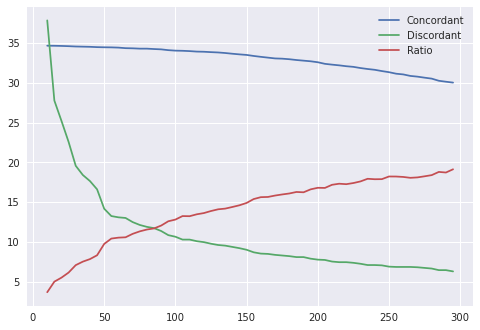

In [26]:

plt.plot(range(10,300,5), array(conc_total)/100 , label = 'Concordant')
plt.plot(range(10,300,5), array(disc_total)/25 , label = 'Discordant')
plt.plot(range(10,300,5), ratio_cd,label ='Ratio'  )
plt.legend()
plt.show()

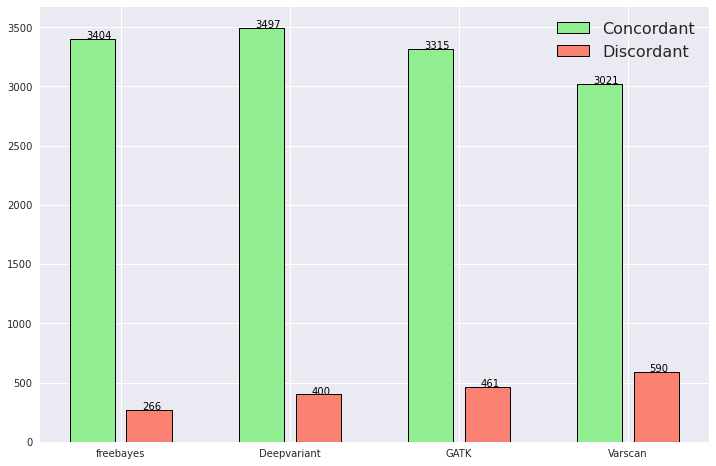

In [27]:
#Quality filter freebayes and GATK 
df_list1 = df_list.copy() 
df_list1[0] = df_list[0][df_list[0]['Otherinfo9']>100]
df_list1[2] = df_list[2][df_list[2]['Otherinfo9']>350]
df_list1[1] = df_list[1][df_list[1]['Otherinfo9']>10]

c_list = []
d_list = []
for i in range(4):
    conc_disc_dic = get_concordance(df_list1[i], blanks[i])
    c_list.append(len(sum([i[0] for i in conc_disc_dic.values()])) )
    d_list.append(len(sum([i[1] for i in conc_disc_dic.values()]))  )

plt.figure(figsize=(12,8))
plt.bar([0,3,6,9], c_list,color = 'lightgreen', edgecolor ='black', label = 'Concordant', linewidth=1)
plt.bar([1,4,7,10], d_list,color = 'salmon',edgecolor ='black', label = 'Discordant' , linewidth=1)
plt.legend(loc=0, fontsize =16, frameon=False,edgecolor ='black')
xticks([0.5,3.5, 6.5,9.5] , ['freebayes', 'Deepvariant', 'GATK', 'Varscan'])
for ind, i in enumerate(range(4)):
    plt.text([0,3,6,9][ind]-0.12, c_list[ind]+1, c_list[ind] , color='black')
    plt.text([1,4,7,10][ind]-0.12, d_list[ind]+1, d_list[ind] , color='black')
plt.tick_params(bottom = False)

plt.show()

- Note: Using the filter column generate in VCF file is not ideal for GATK but works well with freebayes

In [28]:
def cocordance_bw_callers(list_of_dics, concORdisc, print1):
    number_of_conc = []
    for group in dup74:
        all_variants = []
        for ind, caller_dic in enumerate(list_of_dics):
            all_variants.append(caller_dic[str(group)][concORdisc])
        for variant in unique(hstack(all_variants)): 
            number_of_conc.append(list(hstack(all_variants)).count(variant))
    if print1 ==0:
        for i in range(1,5):
            print('{}, {:.2%} Variants in {} Callers'.format(number_of_conc.count(i),
            number_of_conc.count(i)/len(number_of_conc) , i))
    else:
        return number_of_conc    

In [29]:
#Find the overlap of concordant and discordant variants
list_of_dics = []
for i in range(4):
    list_of_dics.append(get_concordance(df_list1[i], blanks[i]))
print('Concordant:\n_________________________')

cocordance_bw_callers(list_of_dics, 0, 0)
print('Discordant:\n_________________________')
cocordance_bw_callers(list_of_dics, 1, 0)

Concordant:
_________________________
200, 5.43% Variants in 1 Callers
186, 5.05% Variants in 2 Callers
515, 13.99% Variants in 3 Callers
2780, 75.52% Variants in 4 Callers
Discordant:
_________________________
1241, 88.39% Variants in 1 Callers
71, 5.06% Variants in 2 Callers
34, 2.42% Variants in 3 Callers
58, 4.13% Variants in 4 Callers


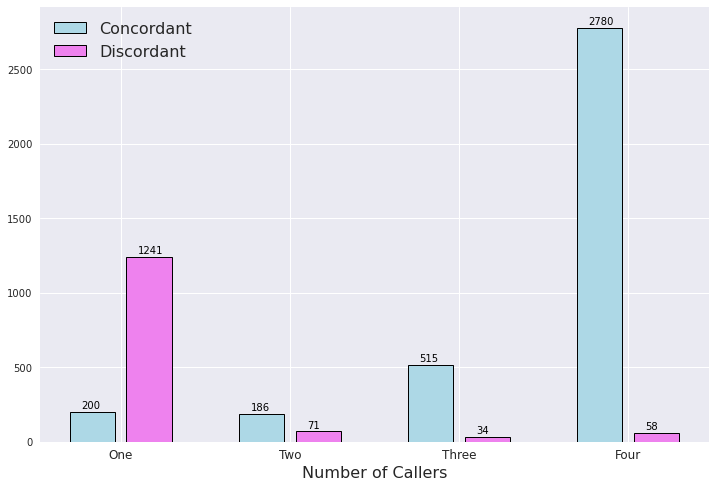

In [30]:
#Just plot the results 
plt.figure(figsize=(12,8))
conc = cocordance_bw_callers(list_of_dics, 0, 1)
disc = try1 = cocordance_bw_callers(list_of_dics, 1, 1)
c = [conc.count(1),conc.count(2),conc.count(3),conc.count(4)]
d = [disc.count(1),disc.count(2),disc.count(3),disc.count(4)]
plt.bar([0,3,6,9], c,color = 'lightblue', edgecolor ='black', label = 'Concordant', linewidth=1)
plt.bar([1,4,7,10], d,color = 'violet',edgecolor ='black', label = 'Discordant' , linewidth=1)
plt.legend(loc=0, fontsize =16, frameon=False,edgecolor ='black')
xticks([0.5,3.5, 6.5,9.5] , ['One', 'Two', 'Three', 'Four'], fontsize =12)
for ind, i in enumerate(range(4)):
    plt.text([0,3,6,9][ind]-0.20, c[ind]+20, c[ind] , color='black')
    plt.text([1,4,7,10][ind]-0.20, d[ind]+20, d[ind] , color='black')
plt.tick_params(bottom = False)
plt.xlabel('Number of Callers', fontsize =16 )
plt.show()

# C. Best Practices GATK <a name="BP"></a>

In [31]:
#Apply quality filters 
df_list[0] = df_list[0][df_list[0]['Otherinfo9']>100]
df_list[2] = df_list[2][df_list[2]['Otherinfo9']>350]
df_list[1] = df_list[1][df_list[1]['Otherinfo9']>10]

In [32]:
#get correct columns names
cols = pd.read_csv('/scratch4/jluo2/drabiza1/ICI_data/BQSR_BAM/columns.txt', sep = '\t', header = None)
cols = cols.loc[0]
cols = list(cols)[9:]
samples = pd.read_csv('PaperON/samples.txt', sep = '\n', header = None)
samps = list(samples[0])

In [33]:
#Rename columns to be consistent
new_cols = {}
for i in cols:
    temp = []
    i = str(i)
    cnt = 0 
    for s in samps: 
        if i in s[:len(i)]: 
            temp.append(s)
    if len(temp) >1:
        cnt1=0
        temp = []
        for s in samps: 
            if i+'_S' in s[:len(i)+2]: 
                temp.append(s)
        if cnt1>1:
            print(i, cnt1)
        elif len(temp)==1:
            new_cols[i] = temp[0]
    elif len(temp)==1: 
        new_cols[i] = temp[0]

In [34]:
#Rename again
new_rename_cols = {}
for ind, i in enumerate(rename_cols):
    new_rename_cols[i] = list(new_cols.values())[ind]


In [35]:
#Filter joint genotyping
def BP_filter(dv, blank, passorfail):
    if passorfail==0:
        dv = dv[dv['Otherinfo10']=='PASS']
    
    df['Alt'] = df['Alt'].replace('0', '-')
    dv = dv[dv['Func.refGene'].isin(['exonic', 'splicing'])]
    dv = dv[np.invert(dv['CLNSIG'].str.contains('Benign'))]
    dv = dv[np.invert(dv['CLNSIG'].str.contains('benign'))]
    dv = dv[np.invert(dv['ExonicFunc.refGene'].str.contains('nonframeshift'))]
    dv = dv[dv['genomicSuperDups']=='.']
    dv = dv[dv['AF'].replace('.', 0).astype(float)<.005]
    dv = dv[dv['ExonicFunc.refGene']!='synonymous SNV']
    keep = dv['CLNSIG'].isin(['Pathogenic', 'Pathogenic/Likely_pathogenic','Likely_pathogenic'])
    path_ind = list(keep[keep].index)
    drop = dv[(dv['ExonicFunc.refGene']=='nonsynonymous SNV')]['ClinPred_score'].replace('.', 0).astype(float)<0.85
    drop = drop[drop].index
    drop_ind = [i for i in drop if i not in path_ind]
    dv = dv.drop(drop_ind)
    blank = '.'
    for samp in list(dv.columns[-666:]):
        ind = dv[samp].str.contains('0/0') | dv[samp].str.contains('0\|0') |  dv[samp].str.contains('\./\.')
        replace_rows = ind[ind]
        dv.loc[replace_rows.index, samp] = blank
    dv = dv[sum(dv[dv.columns[-666:]]!=blank, axis =1)!=0]
    dv = dv[sum(dv[dv.columns[-666:]]!=blank, axis =1)<15] #random number to remove errors
    return dv

In [36]:
#df = pd.read_csv('Manuscript_Exome/BP_files/Annovar_Edit/JC_cohort.both.hg19_multianno.txt', sep = '\t')
#df = df.rename(new_rename_cols, axis =1)
#dv1 = BP_filter(df, '.', 1)
#dv1.to_csv('Manuscript_Exome/SAVED_DF/rarepath_GATK_JC_cohort.both.hg19_multianno.txt', sep = '\t', index = None)

In [37]:
#df = pd.read_csv('/scratch4/jluo2/drabiza1/ICI_data/Manuscript_Exome/JC_cohort.exonic_nonsyn.hg19_multianno.txt', sep = '\t') #Pass only 
#df = df.rename(new_rename_cols, axis =1) 

dv1 = pd.read_csv('Manuscript_Exome/SAVED_DF/rarepath_GATK_JC_cohort.both.hg19_multianno.txt', sep = '\t')
    

In [38]:
dv1.shape

(35315, 803)

In [39]:
c_list = []
d_list = []
for i in range(4):
    conc_disc_dic = get_concordance(df_list[i], blanks[i])
    c_list.append(len(sum([i[0] for i in conc_disc_dic.values()])) )
    d_list.append(len(sum([i[1] for i in conc_disc_dic.values()]))  )


In [40]:
conc_disc_dic = get_concordance(dv1, '.')    
c_list.append(len(sum([i[0] for i in conc_disc_dic.values()])) )
d_list.append(len(sum([i[1] for i in conc_disc_dic.values()]))  )

In [42]:
dv2 = dv1.set_index(dv1['Chr']+'_'+dv1['Start'].astype(str)+'_'+dv1['Ref']+'_'+dv1['Alt'])

- There seems to be something wrong with the filtering process during GATK best practices. 
- I believe it has a lot to do with not using ExcessHet feature (because it is limited to a cohort of unrelated samples)
- Maybe I'm expected to also apply a quality filter? - yes it works

In [45]:

dv2 = dv1.set_index(dv1['Chr']+'_'+dv1['Start'].astype(str)+'_'+dv1['Ref']+'_'+dv1['Alt'])
dv2 = dv2[dv2['Otherinfo9']>350]
c_pass = 0 
c_fail = 0 
d_pass = 0
d_fail = 0 
conc_disc_dic = get_concordance(dv2, '.')    
c_list.append(len(sum([i[0] for i in conc_disc_dic.values()])) )
d_list.append(len(sum([i[1] for i in conc_disc_dic.values()]))  )
for group in dup74:
    c_pass+=sum(dv2.loc[conc_disc_dic[str(group)][0]]['Otherinfo10']=='PASS')
    c_fail+=sum(dv2.loc[conc_disc_dic[str(group)][0]]['Otherinfo10']!='PASS')
    d_pass+=sum(dv2.loc[conc_disc_dic[str(group)][1]]['Otherinfo10']=='PASS')
    d_fail+=sum(dv2.loc[conc_disc_dic[str(group)][1]]['Otherinfo10']!='PASS')


In [46]:
print(c_pass, d_pass)
print(c_fail, d_pass)
print(c_pass+ c_fail)
print(d_fail+ d_pass)

3631 657
403 657
4034
2705


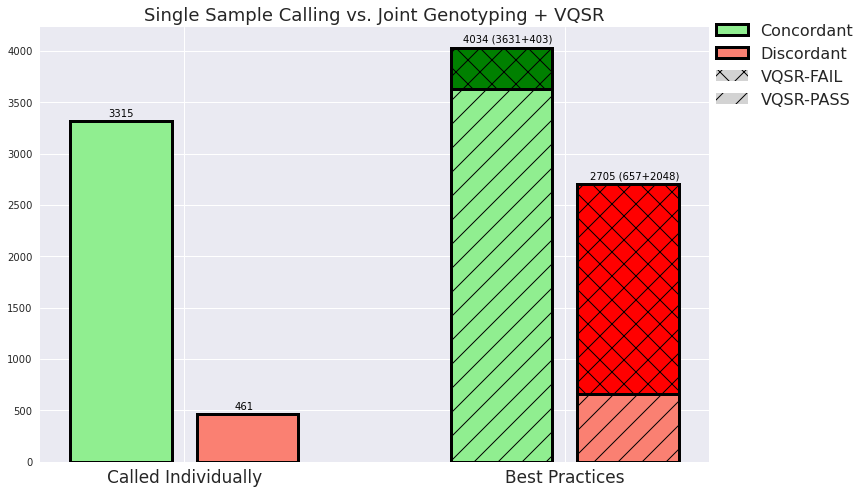

In [47]:
plt.figure(figsize=(12,8))
pre_filt = [c_list[2], d_list[2]]
plt.bar(0, pre_filt[0],color = 'lightgreen', edgecolor ='black', label = 'Concordant', linewidth=3)
plt.bar(1, pre_filt[1],color = 'salmon',edgecolor ='black', label = 'Discordant' , linewidth=3)
plt.bar([3,4], [c_pass, d_pass], color = ['lightgreen', 'salmon'], edgecolor ='black', linewidth=3,  hatch="/" )
plt.bar([3,4], [c_fail, d_fail], bottom = [c_pass, d_pass], color = ['green', 'red'], edgecolor ='black', linewidth=3,  hatch="x" )
plt.bar(1,1, label = 'VQSR-FAIL', hatch="x", color ='lightgrey', linewidth =3)
plt.bar(1,1, label = 'VQSR-PASS', hatch="/", color ='lightgrey', linewidth =3)

plt.legend(loc=(1,0.8), fontsize =16, frameon=False,edgecolor ='black')
xticks([0.5,3.5] , ['Called Individually', 'Best Practices'], fontsize =17)
text = [pre_filt[0], pre_filt[1]]
for ind, i in enumerate([0,1]):
    plt.text(i-.1, text[ind]+50, text[ind] , color='black')
text = [c_pass+c_fail, d_pass+d_fail]
text1 = ['4034 (3631+403)' , '2705 (657+2048)']
for ind, i in enumerate([3,4]):
    plt.text(i-.3, text[ind]+50, text1[ind] , color='black') 
    

#plt.tick_params(bottom = False)
plt.title('Single Sample Calling vs. Joint Genotyping + VQSR', fontsize =18)
plt.show()

# D. DV+GLneuxs <a name="DV_JG"></a>

In [49]:
#Filter joint genotyping
def DV_BP_filter(dv, blank, passorfail):
    if passorfail==0:
        dv = dv[dv['Otherinfo10']=='PASS']

    df['Alt'] = df['Alt'].replace('0', '-')
    
    dv = dv[dv['Func.refGene'].isin(['exonic', 'splicing'])]
    
    dv = dv[np.invert(dv['CLNSIG'].str.contains('Benign'))]
    dv = dv[np.invert(dv['CLNSIG'].str.contains('benign'))]
    dv = dv[np.invert(dv['ExonicFunc.refGene'].str.contains('nonframeshift'))]
    
    dv = dv[dv['genomicSuperDups']=='.']
    dv = dv[dv['AF'].replace('.', 0).astype(float)<.005]
   
    dv = dv[dv['ExonicFunc.refGene']!='synonymous SNV']
    keep = dv['CLNSIG'].isin(['Pathogenic', 'Pathogenic/Likely_pathogenic','Likely_pathogenic'])
    path_ind = list(keep[keep].index)
    
    drop = dv[(dv['ExonicFunc.refGene']=='nonsynonymous SNV')]['ClinPred_score'].replace('.', 0).astype(float)<0.85
    drop = drop[drop].index
    drop_ind = [i for i in drop if i not in path_ind]
    
    dv = dv.drop(drop_ind)
    blank = '.'
    for samp in list(dv.columns[-666:]):
        ind = dv[samp].str.contains('0/0') | dv[samp].str.contains('0\|0') |  dv[samp].str.contains('\./\.') | dv[samp].str.contains('\./0')
        replace_rows = ind[ind]
        dv.loc[replace_rows.index, samp] = blank
    
    dv = dv[sum(dv[dv.columns[-666:]]!=blank, axis =1)!=0]
    
    dv = dv[sum(dv[dv.columns[-666:]]!=blank, axis =1)<15] #random number to remove errors
    return dv

In [50]:
#df = pd.read_csv('Manuscript_Exome/DV_JG/filt_DV_JG.hg19_multianno.txt', sep = '\t')
#sample_order = sort(array(arange(0,666), dtype = str)) #sampes numbers were treated ast strings 
#samples1 = pd.read_csv('Manuscript_Exome/Bam_Samples.txt', sep = '\t', header = None)
#samples1 =samples1[0]
#rename_DVJG = {}
#for ind,col in enumerate(df.columns[-666:]):
#    rename_DVJG[col]=samples1[int(sample_order[ind])].split('/')[1]+'.vcf.gz'
#df = df.rename(rename_DVJG,axis =1)
#df = DV_BP_filter(df, '.', 1)
#df.to_csv('Manuscript_Exome/SAVED_DF/rarepath_DV_JC_cohort.hg19_multianno.txt', sep = '\t', index = None)

In [51]:
df = pd.read_csv('Manuscript_Exome/SAVED_DF/rarepath_DV_JC_cohort.hg19_multianno.txt',sep ='\t')

In [52]:
df = df.set_index(df['Chr']+'_'+df['Start'].astype(str)+'_'+df['Ref']+'_'+df['Alt'])

In [53]:

conc_disc_dic = get_concordance(dv, '.')    
c_dv = len(sum([i[0] for i in conc_disc_dic.values()])) 
d_dv = len(sum([i[1] for i in conc_disc_dic.values()]))  
print(c_dv, d_dv)

3021 590


In [54]:
trial_df = df[df['Otherinfo9']>10]

In [55]:

conc_disc_dic = get_concordance(trial_df, '.')    
c_dv = len(sum([i[0] for i in conc_disc_dic.values()])) 
d_dv = len(sum([i[1] for i in conc_disc_dic.values()]))  
print(c_dv, d_dv)

3673 481


In [56]:
reg_dv = df_list[1]
conc_disc_dic = get_concordance(reg_dv, '.')    
c_dv = len(sum([i[0] for i in conc_disc_dic.values()])) 
d_dv = len(sum([i[1] for i in conc_disc_dic.values()]))  
print(c_dv, d_dv)

3497 400


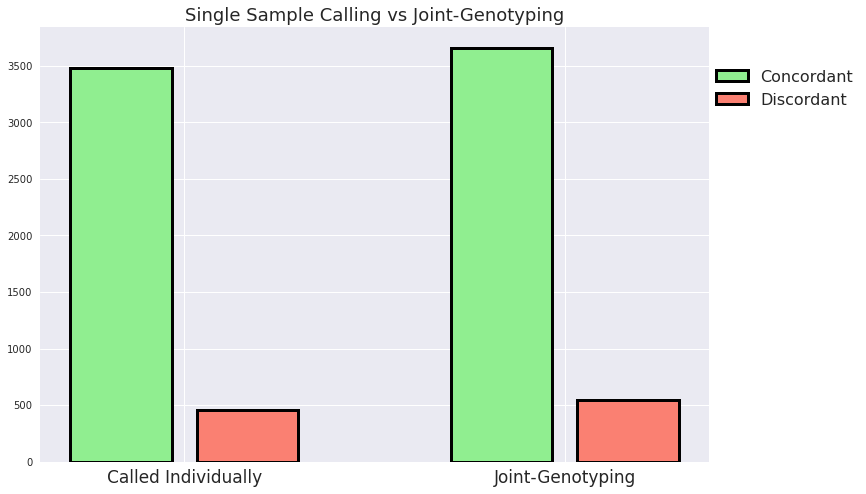

In [57]:
plt.figure(figsize=(12,8))
plt.title('Single Sample Calling vs Joint-Genotyping', fontsize =18)
pre_filt = [c_list[2], d_list[2]]
plt.bar(0, 3479,color = 'lightgreen', edgecolor ='black', label = 'Concordant', linewidth=3)
plt.bar(1, 458,color = 'salmon',edgecolor ='black', label = 'Discordant' , linewidth=3)
plt.bar([3,4], [3660, 549], color = ['lightgreen', 'salmon'], edgecolor ='black', linewidth=3)



plt.legend( fontsize =16, frameon=False,edgecolor ='black', loc=(1,.8))
xticks([0.5,3.5] , ['Called Individually', 'Joint-Genotyping'], fontsize =17)
plt.show()

In [58]:
#NOW ADD config WES 
#df = pd.read_csv('Manuscript_Exome/DV_JG/Filtered/Filt_filt_DV_JG.hg19_multianno.txt', sep = '\t')


In [59]:
#sample_order = sort(array(arange(0,666), dtype = str)) #sampes numbers were treated ast strings 
#samples1 = pd.read_csv('Manuscript_Exome/Bam_Samples.txt', sep = '\t', header = None)
#samples1 =samples1[0]
#rename_DVJG = {}
#for ind,col in enumerate(df.columns[-666:]):
#    rename_DVJG[col]=samples1[int(sample_order[ind])].split('/')[1]+'.vcf.gz'
#df = df.rename(rename_DVJG,axis =1)
#df = DV_BP_filter(df, '.', 1)
#df.to_csv('Manuscript_Exome/SAVED_DF/WES_filt_rarepath_DV_JC_cohort.hg19_multianno.txt', sep = '\t', index = None)

In [60]:
df = pd.read_csv('Manuscript_Exome/SAVED_DF/WES_filt_rarepath_DV_JC_cohort.hg19_multianno.txt', sep = '\t')

In [61]:
conc_disc_dic = get_concordance(df, '.')    
c_dv = len(sum([i[0] for i in conc_disc_dic.values()])) 
d_dv = len(sum([i[1] for i in conc_disc_dic.values()]))  
print(c_dv, d_dv)

2351 147


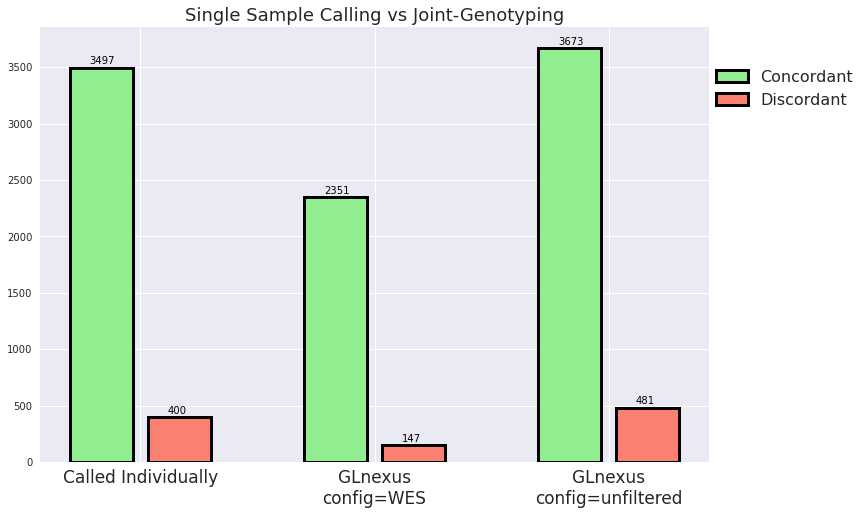

In [62]:
plt.figure(figsize=(12,8))
plt.title('Single Sample Calling vs Joint-Genotyping', fontsize =18)
pre_filt = [c_list[2], d_list[2]]
plt.bar(0, 3497,color = 'lightgreen', edgecolor ='black', label = 'Concordant', linewidth=3)
plt.bar(1, 400,color = 'salmon',edgecolor ='black', label = 'Discordant' , linewidth=3)
plt.bar([3,4], [2351, 147], color = ['lightgreen', 'salmon'], edgecolor ='black', linewidth=3)
plt.bar([6,7], [3673 ,481], color = ['lightgreen', 'salmon'], edgecolor ='black', linewidth=3)

for ind, i in enumerate([0,1,3,4,6,7]):
    plt.text(i-.15,[3497,400,2351, 147,3673, 481][ind]+30,[3497,400,2351, 147,3673 ,481][ind], color='black' )

plt.legend( fontsize =16, frameon=False,edgecolor ='black', loc=(1,.8))
xticks([0.5,3.5, 6.5] , ['Called Individually', 'GLnexus\nconfig=WES', 'GLnexus\nconfig=unfiltered'], fontsize =17)
plt.show()

# E. Comparing GATK and DV <a name="DVvsGATK"></a>

In [65]:
def compare_disc_calls(ind1, ind2):
    dis_dic = list_of_dics[ind1]
    d_d,d_c, d_nc = 0,0, 0
    for group in dis_dic.keys():
        if len(dis_dic[group][1])!=0: #disc
            for v in dis_dic[group][1]:
                if v in list_of_dics[ind2][group][0]:
                    d_c+=1
                elif v in list_of_dics[ind2][group][1]:
                    d_d+=1
                else:
                    d_nc+=1
    print('{} Discordant:\n--------'.format(['freebayes', 'deepvariant', 'gatk', 'varscan'][ind1]))
    for ind, i in enumerate([d_d,d_c, d_nc]):
        print('{} {} in {}'.format(i, ['Disc', 'Conc', 'Not Called'][ind], ['freebayes', 'deepvariant',
                                                                            'gatk', 'varscan'][ind2])) 
                
def compare_conc_calls(ind1, ind2):
    conc_dic = list_of_dics[ind1]
    c_d,c_c, c_nc = 0,0, 0
    for group in conc_dic.keys():
        if len(conc_dic[group][0])!=0: #disc
            for v in conc_dic[group][0]:
                if v in list_of_dics[ind2][group][0]:
                    c_c+=1
                elif v in list_of_dics[ind2][group][1]:
                    c_d+=1
                else:
                    c_nc+=1
    print('{} Concordant:\n--------'.format(['freebayes', 'deepvariant', 'gatk', 'varscan'][ind1]))
    for ind, i in enumerate([c_d,c_c, c_nc]):
        print('{} {} in {}'.format(i, ['Disc', 'Conc', 'Not Called'][ind], ['freebayes', 'deepvariant',
                                                                            'gatk', 'varscan'][ind2])) 
                            
        
    

In [66]:
compare_disc_calls(1,2)
print('')
compare_conc_calls(1,2)
print('')
compare_disc_calls(2,1)
print('')
compare_conc_calls(2,1)

deepvariant Discordant:
--------
84 Disc in gatk
32 Conc in gatk
284 Not Called in gatk

deepvariant Concordant:
--------
5 Disc in gatk
3207 Conc in gatk
285 Not Called in gatk

gatk Discordant:
--------
84 Disc in deepvariant
5 Conc in deepvariant
372 Not Called in deepvariant

gatk Concordant:
--------
32 Disc in deepvariant
3207 Conc in deepvariant
76 Not Called in deepvariant


In [67]:
def print_discordant_calls(ind1, ind2):
    dis_dic = list_of_dics[ind1]
    for group in dis_dic.keys():
        if len(dis_dic[group][1])!=0: #disc
            for v in dis_dic[group][1]:
                ind = variant_index[ind1]==v
                if v in list_of_dics[ind2][group][1]:
                    print('Discordant in '+['freebayes', 'deepvariant', 'gatk', 'varscan'][ind2])
                    print(df_list[ind1].loc[ind[ind].index[0]][eval(group)].to_string() )
                    print('')
                elif v in list_of_dics[ind2][group][0]:
                    print('Concordant in '+['freebayes', 'deepvariant', 'gatk', 'varscan'][ind2])
                    print(df_list[ind1].loc[ind[ind].index[0]][eval(group)].to_string() )
                    print('')
                    
                else :
                    print('No Call in '+['freebayes', 'deepvariant', 'gatk', 'varscan'][ind2])
                    print(df_list[ind1].loc[ind[ind].index[0]][eval(group)].to_string() )
                    print('')

def return_cd_calls(ind1, ind2, cd):
    '''return list of 3 lists that include if (concordant of discordant) calls and variants from caller1 (ind1) are 
    concordant or discordant or not called in caller2 (ind2)
    '''
    return_calls = [[], [], []]
    return_variants = [[], [], []]
    dis_dic = list_of_dics[ind1]
    for group in dis_dic.keys():
        group1 = [group.split(' ')[0].split("'")[1], group.split(' ')[1].split("'")[1] ] # added this
        if len(dis_dic[group][cd])!=0: #disc
            for v in dis_dic[group][cd]:
                ind = variant_index[ind1]==v
                if v in list_of_dics[ind2][group][0]: #conc
                    return_variants[0].append(v)
                    keep = df_list[ind1].loc[ind[ind].index[0]][group1]!=blanks[ind1]
                    return_calls[0].append(df_list[ind1].loc[ind[ind].index[0]][group1][keep].values)

                elif v in list_of_dics[ind2][group][1]: #disc 
                    return_variants[1].append(v)
                    #print(group, eval(group))
                    keep = df_list[ind1].loc[ind[ind].index[0]][group1]!=blanks[ind1]
                    return_calls[1].append(df_list[ind1].loc[ind[ind].index[0]][group1][keep].values)

                else : #not called
                    return_variants[2].append(v)
                    keep = df_list[ind1].loc[ind[ind].index[0]][group1]!=blanks[ind1]
                    return_calls[2].append(df_list[ind1].loc[ind[ind].index[0]][group1][keep].values)
    return return_calls, return_variants


In [68]:
def snp_indel(x):
    bases= x.split('_')[-2:]
    if '-'  in bases:
        return 'InDel'
    elif (len(bases[0])>1) or (len(bases[1])>1):
        return 'InDel'
    else:
        return 'SNP'
    

In [69]:
calls, variants = return_cd_calls(1, 2, 1)


In [70]:
def plot_dv():
    labels = ['Concordant', 'Discordant']
    colors = ['g', 'r']
    for i in range(2):
        GQ, AD = [], []
        calls, variants = return_cd_calls(1, 2, i)
        for ind, status in enumerate(calls):
            for grouping in status: 
                for call in grouping:
                    GQ.append(float(call.split(':')[1]))
                    AD.append(float(call.split(':')[3].split(',')[1]))
            GQ+=GQ
            AD+=AD
        if i ==0:
            plt.scatter(AD, GQ, color =colors[i], label = labels[i])
        else:
            plt.scatter(AD, GQ, color =colors[i], label = labels[i], edgecolor = 'black',linewidths=1.)
    plt.xlabel('AD', fontsize = 16)
    plt.ylabel('GQ', fontsize = 16)
    xlim(0,120)
    plt.legend(loc=(.65,.80),fontsize =15, edgecolor ='black', frameon=True, facecolor ='white')

In [71]:
def plot_dv_compare(calls):
    labels = ['Concordant', 'Discordant', 'No Call']
    colors = ['lime', 'yellow', 'silver']
    for ind, status in enumerate(calls):
        GQ, AD = [], []
        for grouping in status: 
            for call in grouping:
                GQ.append(float(call.split(':')[1]))
                AD.append(float(call.split(':')[3].split(',')[1]))
        plt.scatter(AD, GQ, s= 70, color =colors[ind], label = labels[ind],  edgecolor = 'black',linewidths=1.)
    plt.xlabel('AD', fontsize = 16)
    plt.ylabel('GQ', fontsize = 16)
    xlim(0,120)
    plt.legend(loc=(.65,.70), edgecolor ='black', frameon=True, 
               facecolor ='white', title='GATK Status', fontsize = 16, prop={'size':'large'} )

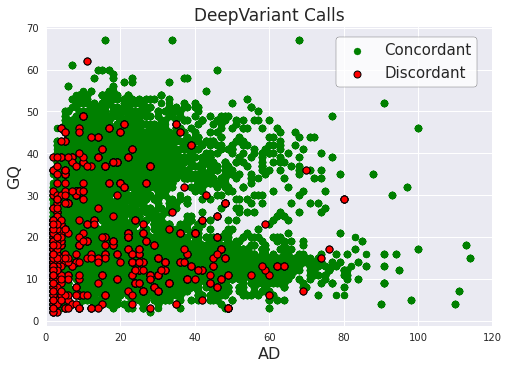

In [72]:
#plt.figure(figsize=(12,8))
plt.title('DeepVariant Calls', fontsize = 17 )
plot_dv()
plt.show()

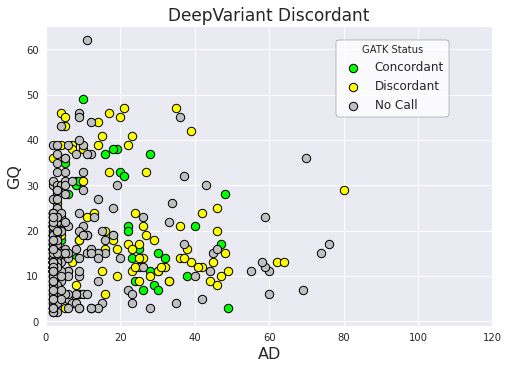

In [73]:
#plt.figure(figsize=(12,8))
plt.title('DeepVariant Discordant', fontsize = 17 )
plot_dv_compare(return_cd_calls(1, 2, 1)[0])

In [74]:
def get_disc_sample(variant, df):
    ind = variant_index[df]==variant
    row = ind[ind].index[0]
    output = []
    for ind, i in enumerate(list_of_dics[df].values()):

        if variant in i[1]:
            group_check = list(list_of_dics[df].keys())[ind]
            for samp in eval(group_check):
                if df_list[df].loc[row][samp]==blanks[df]:
                    output.append(samp)         
    return output

In [75]:
def get_nocall_sample(variant, df):
    ind = variant_index[df]==variant
    row = ind[ind].index[0]
    output = []
    for ind, i in enumerate(list_of_dics[df].values()):
        if variant in i[0]:
            for samp in eval(list(list_of_dics[df].keys())[ind]):
                output.append(samp)
                    
    return output

In [76]:
calls, variants = return_cd_calls(2,1,0)
def gatkcalls_notinDV(df1, df2):
    missed, sor = [], []
    for status in range(1,2):
        for ind1, grouping in enumerate(calls[status]): 
                ind = variant_index[df2]==variants[status][ind1]
                missed += list(df_list[df2].loc[ind[ind].index[0]][get_disc_sample(variants[status][ind1],df1)].values)
                for i in list(df_list[df2].loc[ind[ind].index[0]][get_disc_sample(variants[status][ind1],df1)].values):
                    sor.append(float(df_list[df2].loc[ind[ind].index[0]]['Otherinfo11'].split('SOR=')[1].split(';')[0]))
    for status in range(2,3):
        for ind1, grouping in enumerate(calls[status]): 
                ind = variant_index[df2]==variants[status][ind1]
                missed += list(df_list[df2].loc[ind[ind].index[0]][get_nocall_sample(variants[status][ind1],df2)].values)
                for i in list(df_list[df2].loc[ind[ind].index[0]][get_nocall_sample(variants[status][ind1],df2)].values):
                    sor.append(float(df_list[df2].loc[ind[ind].index[0]]['Otherinfo11'].split('SOR=')[1].split(';')[0]))
    return missed, sor

In [77]:
len(calls[0])

3207

In [89]:
missed = []
sor = []
fs = []
df2 = 2
blank = blanks[df2]
DIC = list_of_dics[2]
for group in DIC.keys():
    group1 = [group.split(' ')[0].split("'")[1], group.split(' ')[1].split("'")[1] ] # added this
    if len(DIC[group][1])!=0:
        for v in DIC[group][1]:
            ind = variant_index[df2]==v
            temp = df_list[df2].loc[ind[ind].index[0]]
            for sample in group1:
                if temp[sample]!=blank:
                    missed.append(temp[sample])
                    sor.append(float(temp['Otherinfo11'].split('SOR=')[1].split(';')[0]))
                    fs.append(float(temp['Otherinfo11'].split('FS=')[1].split(';')[0]))                    

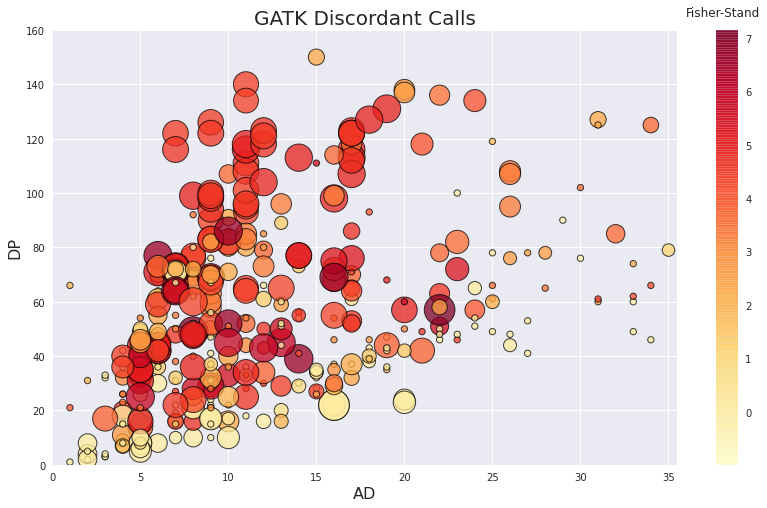

In [141]:
logfs = []
for i in fs: 
    if i ==0: 
        logfs.append(0)
    else: 
        logfs.append(log2(i))
plt.figure(figsize=(14,8))
dp , ad = [], []
gq = []
for i in missed:
    try:
        ad.append(float(i.split(':')[1].split(',')[1]))
        dp.append(float(i.split(':')[2] ) )
        gq.append(float(i.split(':')[3] ) )
    except: 
        print(i)
        pass
#colors = ['g' if i>=95 else 'r' for i in gq] 
sizes = [40 if i<1 else 50*(i+i+i) for i in sor]
#colors = ['g' if i<1 else 'r' for i in sor] 

sc= plt.scatter(ad, dp, s = sizes ,c =logfs, cmap = 'YlOrRd', edgecolor = 'black',  linewidths=1., alpha =.75)
#plt.scatter(-10, 0, color ='red', s = 100, label = 'Strand Bias', edgecolor = 'black',  linewidths=1.)
#plt.scatter(-10, 0, color ='green', s = 100, label = 'No SB', edgecolor = 'black',  linewidths=1.)
#plt.legend(loc= (1,.8), fontsize = 20, frameon=True, edgecolor = 'black', facecolor = 'white')
xlim(-1)
ylim(-5)
plt.title('GATK Discordant Calls',fontsize =20)

plt.xlabel('AD', fontsize = 16)
plt.ylabel('DP', fontsize = 16)

cbar = plt.colorbar()
#cbar.set_label('Fisher-Strand', rotation=90, fontsize=16)
plt.text(36 ,165, 'Fisher-Stand', fontsize =12)

#plt.legend(*sc.legend_elements("sizes", num=6))

xlim(0,35.5)
ylim(0,160)


Text(0, 0.5, 'DP')

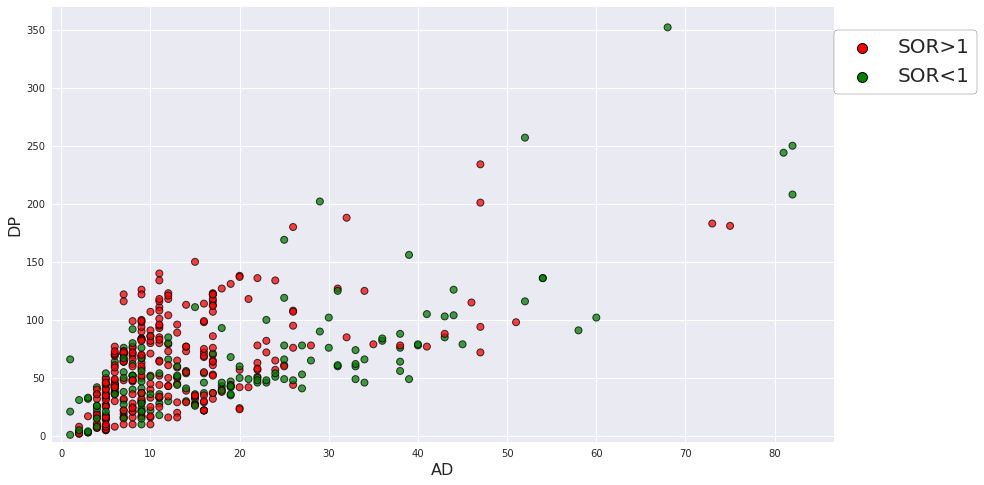

In [73]:

plt.figure(figsize=(14,8))
dp , ad = [], []
gq = []
#missed, sor = gatkcalls_notinDV(1,2)
#missed.remove(missed[17])  #error 
#sor.remove(sor[17])

#missed.remove(missed[sor.index(max(sor))] )
#sor.remove(max(sor))
#missed.remove(missed[sor.index(max(sor))]  )
#sor.remove(max(sor))
for i in missed:
    try:
        ad.append(float(i.split(':')[1].split(',')[1]))
        dp.append(float(i.split(':')[2] ) )
        gq.append(float(i.split(':')[3] ) )
    except: 
        print(i)
        pass
colors = ['r' if i>=1 else 'g' for i in sor] 
#sizes = [40 if i<1 else 50*(i+i+i) for i in sor]
plt.scatter(ad, dp, color =colors, edgecolor = 'black',  linewidths=1., alpha =.75)
plt.scatter(-10, 0, color ='red', s = 100, label = 'SOR>1', edgecolor = 'black',  linewidths=1.)
plt.scatter(-10, 0, color ='green', s = 100, label = 'SOR<1', edgecolor = 'black',  linewidths=1.)
plt.legend(loc= (1,.8), fontsize = 20, frameon=True, edgecolor = 'black', facecolor = 'white')
xlim(-1)
ylim(-5)
#plt.title('GATK Concordant Calls not in DV',fontsize =24)
plt.xlabel('AD', fontsize = 16)
plt.ylabel('DP', fontsize = 16)

Text(0, 0.5, 'DP')

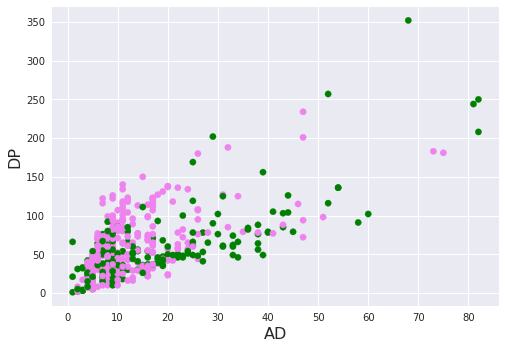

In [74]:
dp , ad = [], []
gq = []
#missed, sor = gatkcalls_notinDV(1,2)
for i in missed:
    ad.append(float(i.split(':')[1].split(',')[1]))
    dp.append(float(i.split(':')[2] ) )
    gq.append(float(i.split(':')[3] ) )
colors = ['violet' if i>=1 else 'g' for i in sor] 
#sizes = [40 if i<1 else 40*i for i in sor]
sizes =40
plt.scatter(ad, dp, color =colors, s = sizes)
plt.xlabel('AD', fontsize = 16)
plt.ylabel('DP', fontsize = 16)

In [75]:
missed = []
sor = []
df2 = 1
blank = blanks[df2]
DIC = list_of_dics[df2]
for group in DIC.keys():
    group1 = [group.split(' ')[0].split("'")[1], group.split(' ')[1].split("'")[1] ] # added this
    if len(DIC[group][1])!=0:
        for v in DIC[group][1]:
            ind = variant_index[df2]==v
            temp = df_list[df2].loc[ind[ind].index[0]]
            for sample in group1:
                if temp[sample]!=blank:
                    missed.append(temp[sample]
                                 )
                    #sor.append(float(temp['Otherinfo11'].split('SOR=')[1].split(';')[0]))
            

Text(0, 0.5, 'DP')

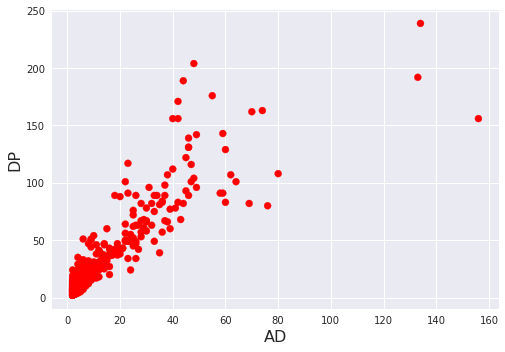

In [76]:
dp , ad = [], []
gq = []
#missed, sor = gatkcalls_notinDV(1,2)
for i in missed:
    ad.append(float(i.split(':')[3].split(',')[1]))
    dp.append(float(i.split(':')[2] ) )
    gq.append(float(i.split(':')[1] ) )
colors = ['g' if i>=95 else 'r' for i in gq] 
#sizes = [40 if i<1 else 40*i for i in sor]
plt.scatter(ad, dp, color =colors)
plt.xlabel('AD', fontsize = 16)
plt.ylabel('DP', fontsize = 16)

## F. UPSET Plot  <a name="UPSET"></a>

In [250]:
import itertools 
groups = list(list_of_dics[0].keys())
upset_data = array(0)
for group in groups: 
    call_sample = []
    length_sample = []
    for caller in range(4):
        call_sample.append(list_of_dics[caller][group][1]  ) #conc or disc
        length_sample.append(len(list_of_dics[caller][group][1]))#conc or disc
    master = np.array(call_sample)
    length = np.array(length_sample)
    tf = [[], [], [], []]
    count = []
    for num in range(1,5):
        for i in itertools.combinations([0,1,2,3], num): #Create every combination of callers from 1 to 4 
            i = list(i)
            for pos in range(4): #callers- if caller in iteration assign True
                if pos in i: 
                    tf[pos].append(True)
                else: 
                    tf[pos].append(False)
            ADD = 0 
            for call in unique(concatenate(master[i])): 
                cnt = 0 
                for each in i: 
                    if call in call_sample[each] :
                        cnt +=1
                if cnt == len(i):
                    cnt = 0 
                    for number in [0,1,2,3]: 
                        if number not in i: 
                            if call not in call_sample[number]:
                                cnt +=1 
                    if cnt == (4-len(i)):
                        ADD +=1
                        #print('yes')    
            count.append(ADD)            
    #print(count, i)
    upset_data =  upset_data+array(count)  
    #print(group)
    
        

In [251]:
#get upset_data 
#EXOME Targeted -unfiltered
upsetdf = pd.DataFrame()
for i in range(4):
    upsetdf[i] = tf[i]
upsetdf['Count'] = upset_data
upsetdf= upsetdf.rename(columns={0:'freebayes',1: 'DeepVariant', 2:'GATK', 3:'Varscan'})
upsetdf = upsetdf.set_index(['freebayes', 'DeepVariant','GATK', 'Varscan'])#.sort_index()
upset_series = upsetdf.squeeze()

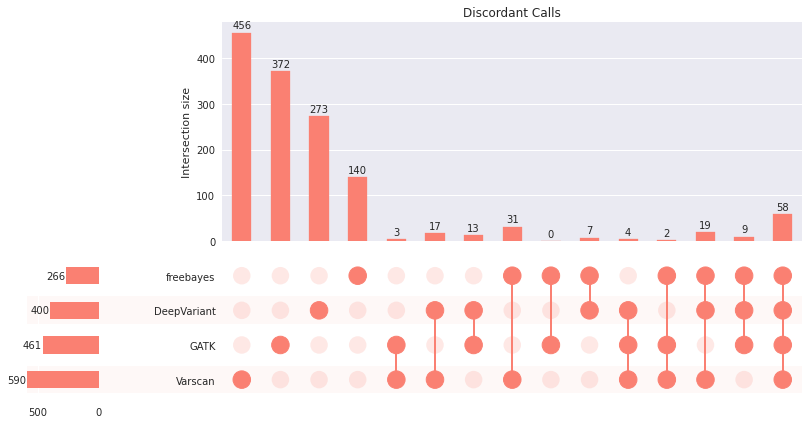

In [252]:
#get upset_data 
#EXOME Targeted -unfiltered
from matplotlib import pyplot as plt
from upsetplot import generate_counts, plot

fig = plt.figure(figsize=(10, 3))
#plot(upset_series,fig = fig,element_size=50, facecolor="limegreen")#, show_counts=True, orientation='vertical')
plot(upset_series,fig = fig,element_size=50, facecolor="salmon", show_counts=True)#, show_counts=True, orientation='vertical')
plt.title('Discordant Calls')
#plt.suptitle('Intersection between Callers', fontsize = 17)
plt.show()

In [119]:
g_metrics = [[], [], []]
d_metrics = [[], [], []]
for group in dup74:
    for samp in group:
        samp = samp.split('.bam')[0]
        df = pd.read_csv('Manuscript_Exome/RESULTS/DV_RESULTS/{}/summary.txt'.format(samp), sep = '\s+')
        d_metrics[0].append(df['Precision'].loc[2])
        d_metrics[1].append(df['Sensitivity'].loc[2])
        d_metrics[2].append(df['F-measure'].loc[2])
        df = pd.read_csv('Manuscript_Exome/RESULTS/GATK_RESULTS/{}/summary.txt'.format(samp), sep = '\s+')
        g_metrics[0].append(df['Precision'].loc[2])
        g_metrics[1].append(df['Sensitivity'].loc[2])
        g_metrics[2].append(df['F-measure'].loc[2])

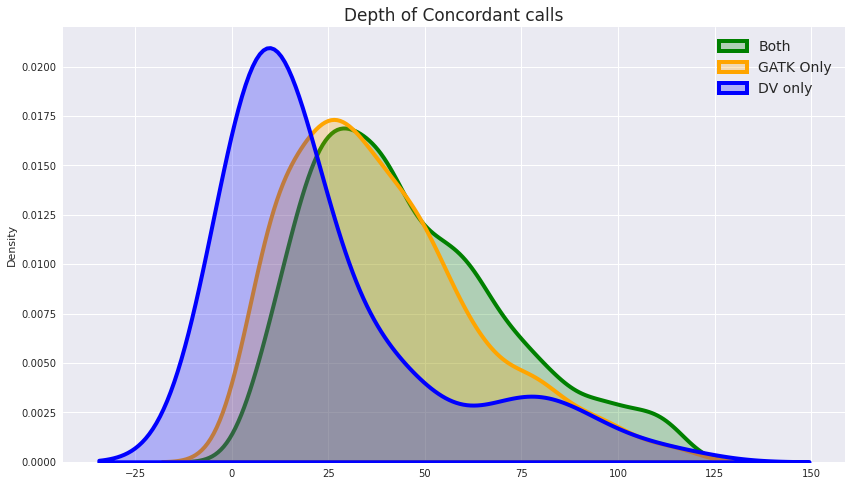

In [175]:
plt.figure(figsize=(14,8))
plt.title('Depth of Concordant calls', fontsize =17)
for i in range(3):
    sns.distplot(array(master_depth[i])[array(master_depth[i])<120], hist=False, kde=True, 
             bins=int(180/5), color = ['green', 'orange', 'blue'][i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade':True}, label =['Both', 'GATK Only', 'DV only'][i])
plt.legend(fontsize=14)
plt.show()


In [ ]:
#heres what i want to do
#Drop the low coverage
#1. Remove sb from GATK only 



## 3. Compare quality Metrics <a name="QualityMetrics"></a>


In [ ]:
c_call={}
d_call={}
cnt =0
for caller in ['freebayes', 'deepvariant', 'gatk', 'varscan']:
    c_call[caller]=[]
    d_call[caller]=[]
    repdf = df_list[cnt]
    blank = blanks[cnt]
    d = 0
    c = 0
    for ind, group in enumerate(dup74):
        temp = []
        temp1 = [] #to see if all the concordants are the same across callers
        temp2= []
        for ind1, samp in enumerate(group):
            indexes = repdf[samp][repdf[samp]!=blank].index
            temp.append(indexes)
        unq_ind, cnts = unique(hstack(temp), return_counts =True)
        for idx in unq_ind: 
            if list(hstack(temp)).count(idx) == len(group):
                c_call[caller] =  c_call[caller]+ list(repdf.loc[idx][group].values)
                
            else:
                for samp in group:
                    if repdf.loc[idx][samp] != blanks[cnt]:
                        d_call[caller].append(repdf.loc[idx][samp])

    cnt +=1

In [ ]:
#Collect quality values 
dgatk_ad = []
dgatk_dp = []
dgatk_gq = []
dgatk_vaf = []
for call in d_call['gatk']:
    try: 
        dgatk_dp.append(float(call.split(':')[2] ) )
        dgatk_gq.append(float(call.split(':')[3] ) )
        dgatk_ad.append(float(call.split(':')[1].split(',')[1] ) )
        dgatk_vaf.append(dgatk_ad[-1]/dgatk_dp[-1])
    except: 
        pass
    
cgatk_ad = []
cgatk_dp = []
cgatk_gq = []
cgatk_vaf = []
for call in c_call['gatk']:
    cgatk_dp.append(float(call.split(':')[2] ) )
    cgatk_gq.append(float(call.split(':')[3] ) )
    cgatk_ad.append(float(call.split(':')[1].split(',')[1] ) )
    cgatk_vaf.append(cgatk_ad[-1]/cgatk_dp[-1])
AD = [cgatk_ad, dgatk_ad]
GQ = [cgatk_gq, dgatk_gq]
DP = [cgatk_dp, dgatk_dp]
VAF = [cgatk_vaf, dgatk_vaf]

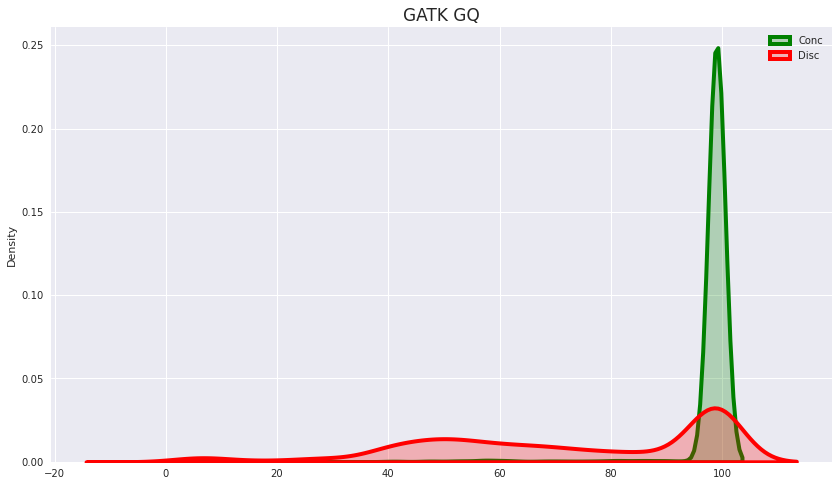

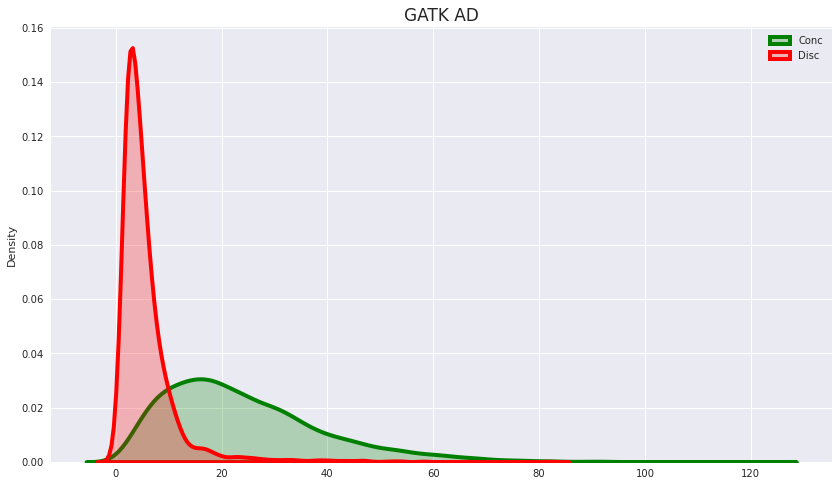

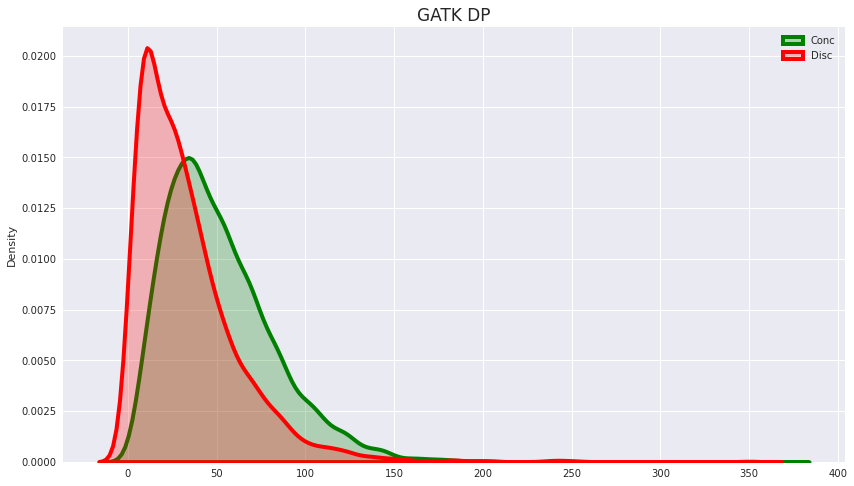

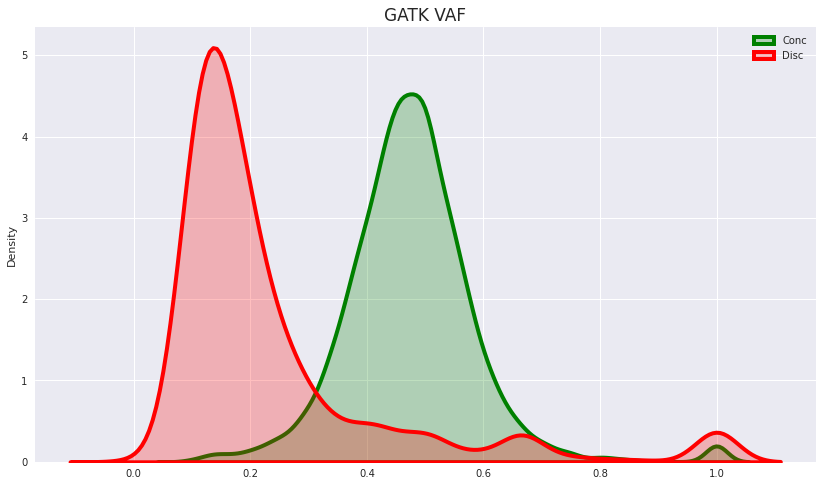

In [ ]:
plt.figure(figsize=(14,8))
plt.title('GATK GQ', fontsize =17)
for i in range(2):
    sns.distplot(GQ[i], hist=False, kde=True, 
             bins=int(180/5), color = ['green', 'red'][i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade':True}, label =['Conc', 'Disc'][i])
plt.legend()
plt.show()
plt.figure(figsize=(14,8))
plt.title('GATK AD', fontsize =17)
for i in range(2):
    sns.distplot(AD[i], hist=False, kde=True, 
             bins=int(180/5), color = ['green', 'red'][i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade':True}, label =['Conc', 'Disc'][i])
plt.legend()
plt.show()
plt.figure(figsize=(14,8))
plt.title('GATK DP', fontsize =17)
for i in range(2):
    sns.distplot(DP[i], hist=False, kde=True, 
             bins=int(180/5), color = ['green', 'red'][i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade':True}, label =['Conc', 'Disc'][i])
plt.legend()
plt.show()

plt.figure(figsize=(14,8))
plt.title('GATK VAF', fontsize =17)
for i in range(2):
    sns.distplot(VAF[i], hist=False, kde=True, 
             bins=int(180/5), color = ['green', 'red'][i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade':True}, label =['Conc', 'Disc'][i])
plt.legend()
plt.show()

In [ ]:
#GET SOR and FS
sor_c = []
fs_c = []
sor_d = []
fs_d = []
cnt =2

repdf = df_list[cnt]
blank = blanks[cnt]
d = 0
c = 0
for ind, group in enumerate(dup74):
    temp = []
    temp1 = [] #to see if all the concordants are the same across callers
    temp2= []
    for ind1, samp in enumerate(group):
        indexes = repdf[samp][repdf[samp]!=blank].index
        temp.append(indexes)
    unq_ind, cnts = unique(hstack(temp), return_counts =True)
    for idx in unq_ind: 
        if list(hstack(temp)).count(idx) == len(group):
            sor_c.append(float(repdf.loc[idx]['Otherinfo11'].split('SOR=')[1].split(';')[0]))
            fs_c.append(float(repdf.loc[idx]['Otherinfo11'].split('FS=')[1].split(';')[0]))

        else:
            sor_d.append(float(repdf.loc[idx]['Otherinfo11'].split('SOR=')[1].split(';')[0]))
            fs_d.append(float(repdf.loc[idx]['Otherinfo11'].split('FS=')[1].split(';')[0]))



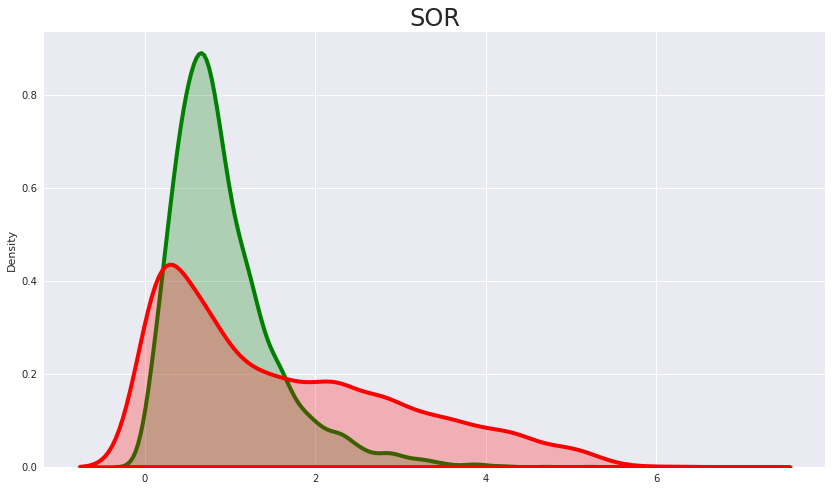

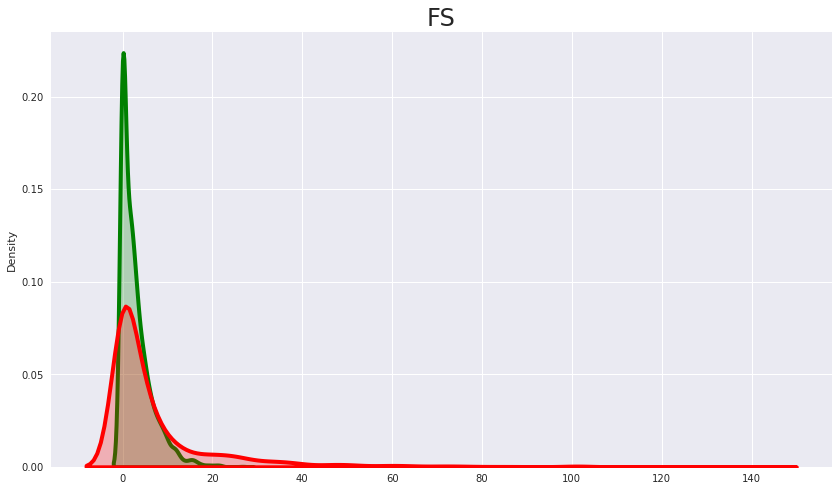

In [ ]:
plt.figure(figsize=(14,8))


plt.title('SOR', fontsize =24)
for i in range(2):
    sns.distplot([sor_c, sor_d][i], hist=False, kde=True, 
             bins=int(180/5), color = ['green', 'red'][i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade':True}, label =['Conc', 'Disc'][i])
#plt.legend(loc=(1,1))
plt.show()

plt.figure(figsize=(14,8))
plt.title('FS', fontsize =24)
for i in range(2):
    sns.distplot([fs_c, fs_d][i], hist=False, kde=True, 
             bins=int(180/5), color = ['green', 'red'][i], 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4, 'shade':True}, label =['Conc', 'Disc'][i])
#plt.legend(loc=(1,1))
plt.show()